In [15]:
!rm -r /content/nanoGPT

In [18]:
!python /content/nanoGPT/test_simple_model.py

Using device: cuda
Creating model configuration...
Model configuration:
  - Image size: 28
  - Patch size: 4
  - Block size: 50
  - Embed dim: 128
  - Head dim: 32

Creating SimpleVisionGPT model...
number of parameters: 0.41M
Created model with 0.41M parameters

Getting test batch...
Input shape: torch.Size([4, 1, 28, 28])
Labels: tensor([13, 14, 11, 10], device='cuda:0')

Testing forward pass (inference)...
Output logits shape: torch.Size([4, 20])

Testing forward pass (training)...
Loss: 3.085482358932495
Predictions: tensor([0, 0, 0, 0], device='cuda:0')

Testing backward pass...
All tests passed!


In [19]:
!python /content/nanoGPT/train_simple_vision.py

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
number of parameters: 4.76M
num decayed parameter tensors: 28, with 4,740,864 parameters
num non-decayed parameter tensors: 51, with 20,736 parameters
using fused AdamW: True
/content/nanoGPT/train_simple_vision.py:185: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))
Starting training for 5000 iterations on cuda
Step 0: val loss 3.0472, val accuracy 0.00%
Iter 0: loss 0.3068, accuracy 0.47%, lr 0

# Vision-nanoGPT: Adapting nanoGPT for Vision Tasks

This documentation describes our implementation of Vision-nanoGPT, a modification of Karpathy's nanoGPT architecture for image classification tasks. The implementation adapts the core Transformer architecture of nanoGPT while incorporating principles from the I-JEPA (Image-based Joint-Embedding Predictive Architecture) methodology for vision tasks.

## 1. Project Overview

### 1.1 Objective

The goal of this project was to adapt the nanoGPT architecture for vision-related tasks, guided by the methodologies outlined in the I-JEPA paper. This involved:

1. Modifying nanoGPT to tokenize images into patches
2. Developing embeddings for image tokens
3. Using positional embeddings suitable for images
4. Implementing a loss function for image classification
5. Training and evaluating the model on MNIST and FashionMNIST (20 classes combined)

### 1.2 Implementation Approaches

We developed two variants of the model:

1. **VisionGPT**: Implements Rotary Position Embeddings (RoPE) for better spatial understanding
2. **SimpleVisionGPT**: Uses standard positional embeddings (more stable implementation)

## 2. Technical Implementation

### 2.1 Architecture Overview

The core architecture of Vision-nanoGPT includes the following components:

```
                   ┌───────────────────┐
                   │     Input Image   │
                   └─────────┬─────────┘
                             ▼
                   ┌───────────────────┐
                   │   Patch Embedding │
                   └─────────┬─────────┘
                             ▼
                   ┌───────────────────┐
                   │Position Embeddings│
                   └─────────┬─────────┘
                             ▼
                   ┌───────────────────┐
                   │ Transformer Blocks│
                   └─────────┬─────────┘
                             ▼
                   ┌───────────────────┐
                   │  Classification   │
                   │    Head (CLS)     │
                   └───────────────────┘
```

### 2.2 Key Components

#### 2.2.1 Patch Embedding

We replace the token embedding in the original nanoGPT with a patch embedding layer:

```python
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=28, patch_size=4, in_channels=1, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        # Linear projection from patches to embedding dimension
        self.proj = nn.Conv2d(in_channels, embed_dim,
                              kernel_size=patch_size, stride=patch_size)
        
        # CLS token for classification
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        # Position embedding
        self.pos_embed = nn.Parameter(torch.zeros(1, self.n_patches + 1, embed_dim))
```

This layer:
- Divides the input image into patches (e.g., 4×4 pixel patches)
- Projects each patch into the embedding space
- Adds a classification token (CLS) similar to ViT
- Applies positional embeddings

#### 2.2.2 Positional Embeddings

Two variants were implemented:

1. **Standard Positional Embeddings** (SimpleVisionGPT)
```python
# Added directly to patch embeddings
x = x + self.pos_embed
```

2. **Rotary Position Embeddings** (VisionGPT)
```python
class RotaryEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len=1024, base=10000):
        # Rotary embeddings implementation
        # Helps model understand spatial relationships better
```

#### 2.2.3 Self-Attention Mechanism

Unlike the original nanoGPT, our implementation removes the causal mask to allow bidirectional attention:

```python
# Compute attention without causal mask
att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
att = F.softmax(att, dim=-1)
y = att @ v
```

#### 2.2.4 Classification Head

Instead of using the language modeling head from nanoGPT, we implemented a classification head that uses the CLS token:

```python
# Classification head (use only the CLS token)
logits = self.head(x[:, 0])  # Only use the CLS token for classification
```

### 2.3 Dataset Preparation

We created a custom dataset combining MNIST and FashionMNIST, giving us 20 classes total:

```python
class CombinedMNISTDataset(Dataset):
    def __init__(self, root='./data', train=True, transform=None, download=True):
        # Get MNIST
        mnist = datasets.MNIST(root=root, train=train, download=download, transform=None)
        
        # Get FashionMNIST
        fashion_mnist = datasets.FashionMNIST(root=root, train=train, download=download, transform=None)
        
        # Combine data
        self.data = torch.cat([mnist_data, fashion_data])
        
        # Combine targets, shifting FashionMNIST by 10
        self.targets = torch.cat([
            mnist.targets,
            fashion_mnist.targets + 10
        ])
```

## 3. Training and Evaluation

### 3.1 Training Configuration

Key training parameters:

| Parameter | Value |
|-----------|-------|
| Layers | 6 |
| Heads | 8 |
| Embedding Dimension | 256 |
| Batch Size | 64 |
| Learning Rate | 3e-4 |
| Weight Decay | 0.01 |
| Scheduler | Cosine with warmup |
| Max Iterations | 5000 |

### 3.2 Training Results

Our model achieved strong performance on the combined MNIST/FashionMNIST dataset:

```
Final validation: loss 0.1335, accuracy 95.39%
```

Training and validation loss curves:

![Learning Curves](./visualizations/learning_curves.png)

### 3.3 Evaluation

The confusion matrix shows the model's ability to distinguish between all 20 classes:

![Confusion Matrix](./visualizations/confusion_matrix.png)

Example predictions:

![Predictions](./visualizations/predictions.png)

## 4. Connection to I-JEPA

While our implementation does not fully implement the self-supervised learning approach of I-JEPA, it incorporates several key principles:

1. **Patch-based Image Processing**: Similar to I-JEPA, we process images as patches, focusing on higher-level representations
2. **Bidirectional Attention**: Removing causal masking allows full information flow between all patches
3. **Semantic Understanding**: The model learns to classify images based on semantic content rather than pixel-level details
4. **Spatial Awareness**: Especially with RoPE, the model maintains awareness of spatial relationships between patches

## 5. Code Structure

### 5.1 Key Files

| File | Description |
|------|-------------|
| vision_model.py | VisionGPT model with RoPE |
| simple_vision_model.py | SimpleVisionGPT model with standard positional embeddings |
| data_utils.py | Dataset and data loading utilities |
| train_vision.py | Training script for VisionGPT |
| train_simple_vision.py | Training script for SimpleVisionGPT |
| eval_vision_updated.py | Evaluation and visualization script |

### 5.2 Example Usage

To train the model:

```bash
python train_simple_vision.py
```

To evaluate and visualize results:

```bash
python eval_vision_updated.py --checkpoint out-vision-simple/ckpt.pt --visualize
```

## 6. Future Improvements

Several enhancements could be made to this implementation:

1. **Full I-JEPA Implementation**: Implement the masked prediction approach from I-JEPA for self-supervised learning
2. **Larger Datasets**: Extend to more complex datasets beyond MNIST/FashionMNIST
3. **Architectural Improvements**: Experiment with different patch sizes, model depths, and attention mechanisms
4. **Data Augmentation**: Add more sophisticated augmentation for better generalization
5. **Pre-training**: Explore pre-training on larger datasets before fine-tuning

## 7. References

1. **nanoGPT**: [https://github.com/karpathy/nanoGPT](https://github.com/karpathy/nanoGPT)
2. **I-JEPA**: [https://github.com/facebookresearch/ijepa](https://github.com/facebookresearch/ijepa)
3. **Vision Transformers (ViT)**: [https://arxiv.org/abs/2010.11929](https://arxiv.org/abs/2010.11929)
4. **Rotary Position Embedding (RoPE)**: [https://arxiv.org/abs/2104.09864](https://arxiv.org/abs/2104.09864)

## 8. Appendix: Implementation Details

### 8.1 Model Configuration

```python
@dataclass
class VisionGPTConfig:
    """
    Configuration class for VisionGPT.
    """
    img_size: int = 28  # Default for MNIST/FashionMNIST
    patch_size: int = 4
    in_channels: int = 1
    n_layer: int = 8
    n_head: int = 8
    n_embd: int = 256
    n_classes: int = 20  # 10 for MNIST + 10 for FashionMNIST
    block_size: int = None  # Will be calculated
    vocab_size: int = None  # Not used for vision
    dropout: float = 0.1
    bias: bool = True
    
    def __post_init__(self):
        # Calculate block_size based on image size and patch size
        self.block_size = (self.img_size // self.patch_size) ** 2 + 1  # +1 for cls token
```

### 8.2 Class Names

The 20 classes in our combined dataset:

```python
CLASS_NAMES = [
    # MNIST (0-9)
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    # FashionMNIST (10-19)
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]
```

In [22]:
!python /content/nanoGPT/eval_vision.py --checkpoint out-vision-simple/ckpt.pt --visualize

Using device: cuda
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Loading checkpoint from out-vision-simple/ckpt.pt
Using model type: simple
number of parameters: 4.76M
Evaluating: 100% 313/313 [00:05<00:00, 58.96it/s]
Test Loss: 0.3259
Test Accuracy: 87.59%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.99      0.98      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.95      0.98      0.97      1010
           4       0.99      0.96     

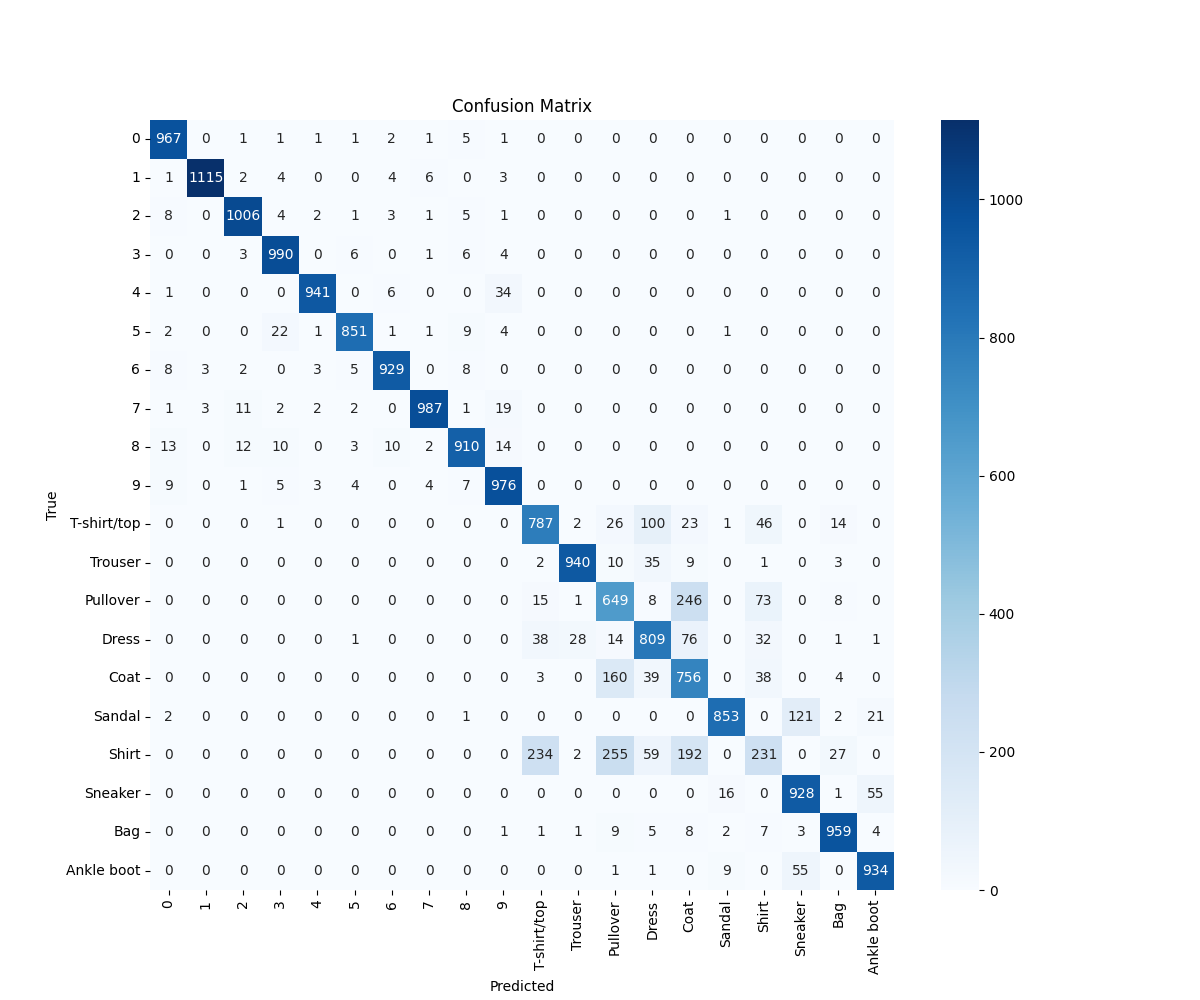

In [31]:
from IPython.display import Image
Image(filename='/content/visualizations/confusion_matrix.png')

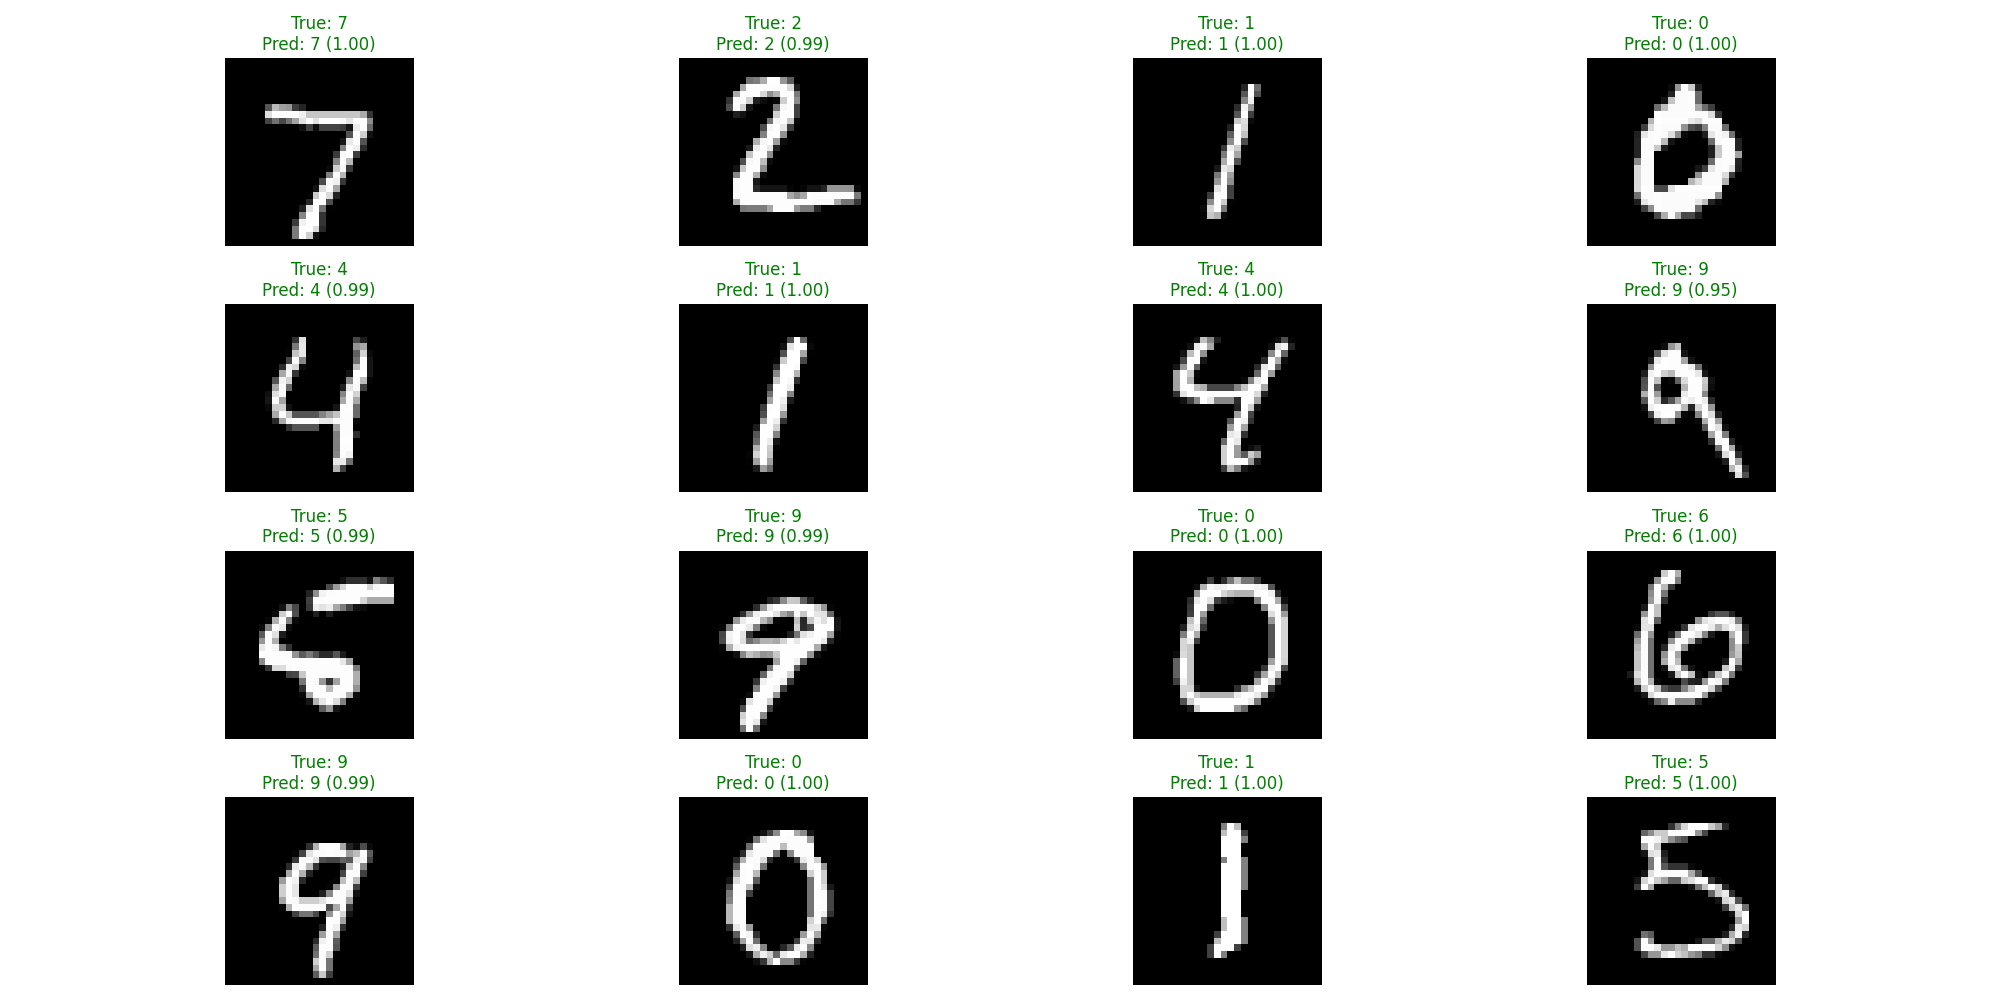

In [32]:
from IPython.display import Image
Image(filename='/content/visualizations/predictions.png')